# **Edge-Centric Model Training**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
print(f"{'torch:':<20} {torch.__version__}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{'device:':<20} {device}")

import numpy as np
import math
import random
print(f"{'numpy:':<20} {np.__version__}")

import matplotlib.pyplot as plt
print(f"{'matplotlib:':<20} {plt.matplotlib.__version__}")

from tqdm import tqdm

import logger
print(f"{'logger (custom):':<20} loaded")

from Models.Architectures.edgeGNN import EdgeCentricNetwork
from DataManagement.data import financialDataset

torch:               2.7.1+cu118
device:              cuda
numpy:               2.2.4
matplotlib:          3.10.3
logger (custom):     loaded


In [2]:
dataset = financialDataset()

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data_load.py:38: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sector_data = yf.download(tickers=list(sector_mapping.keys()), start=start_date, end=end_date)
[*********************100%***********************]  11 of 11 completed


Downloaded yfinance sector data for =:
-> Keys: ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLC']
-> Values: listdict_values(['Technology', 'Financials', 'Energy', 'Health Care', 'Industrials', 'Consumer Staples', 'Consumer Discretionary', 'Utilities', 'Materials', 'Real Estate', 'Communication Services'])
Flattening Column Labels to Remove Tuple-Based Column Structure... & Shifting Date into Column
* Done Preprocessing and Organizing Data *

=== Checking Download Uniformity ===
XLK: 1254 rows with data
XLF: 1254 rows with data
XLE: 1254 rows with data
XLV: 1254 rows with data
XLI: 1254 rows with data
XLP: 1254 rows with data
XLY: 1254 rows with data
XLU: 1254 rows with data
XLB: 1254 rows with data
XLRE: 1254 rows with data
XLC: 1254 rows with data
✓ All sectors have same number of dates
Common dates: 1254
XLK len: 1254
XLF len: 1254
XLE len: 1254
XLV len: 1254
XLI len: 1254
XLP len: 1254
XLY len: 1254
XLU len: 1254
XLB len: 1254
XLRE len: 1254
XLC len: 12

c:\Users\lordw\OneDrive\Documents\ML\MLprojects\AlphaGrid\DataManagement\data.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  feature_data = torch.tensor(data=feature_data, dtype=torch.float32).transpose(0, 1)


In [3]:
num_samples = len(dataset)

train_split = 0.8
test_split = 0.2

train_size = int(train_split * num_samples)
test_size = num_samples - train_size

train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
test_dataset = torch.utils.data.Subset(dataset, list(range(train_size, num_samples)))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

sample_batch = next(iter(train_loader))
print(f"Batch Feature Dim: {sample_batch[0].shape}")
print(f"Batch Target Dim: {sample_batch[1].shape}")
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")

Batch Feature Dim: torch.Size([64, 11, 89])
Batch Target Dim: torch.Size([64, 11])
Train Dataset Length: 978
Test Dataset Length: 245


In [4]:
model = EdgeCentricNetwork(num_nodes=dataset.num_sectors, directed=True, edge_dim=10, node_dim=dataset.features.shape[2])
model.to(device)
model

EdgeCentricNetwork(
  (edge_updater): Sequential(
    (0): Linear(in_features=178, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
  (regression): Sequential(
    (0): Linear(in_features=110, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
LR = 3.5e-5
optimizer = optim.Adam(params=model.parameters(), lr=LR)
criterion = nn.SmoothL1Loss()

In [ ]:
epoch_num = 1500

epoch_losses = []
batch_losses = []

model.train()
for epoch in range(epoch_num):
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epoch_num}]", leave=False)

    for features, targets in train_loader:
        features = features.to(device)
        targets = targets.unsqueeze(2).to(device)

        optimizer.zero_grad()

        output = model(features)

        loss = criterion(output, targets)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    epoch_losses.append(epoch_loss / len(train_loader))
    if epoch % 20 == 0:
        print(f"Epoch [{epoch+1}/{epoch_num}] Loss: {epoch_losses[-1]:.6f}")

Epoch [1/1250]:   0%|          | 0/16 [00:01<?, ?it/s, loss=499]    

Epoch [1/1250] Loss: 1102.301201


Epoch [21/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=21.5]

Epoch [21/1250] Loss: 37.932368


Epoch [41/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=18.3]

Epoch [41/1250] Loss: 24.379467


Epoch [61/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=27.1]

Epoch [61/1250] Loss: 22.275817


Epoch [81/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=28.9]

Epoch [81/1250] Loss: 29.309595


Epoch [101/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=22.8]

Epoch [101/1250] Loss: 18.691309


Epoch [121/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=8.49]

Epoch [121/1250] Loss: 18.177829


Epoch [141/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=24.1]

Epoch [141/1250] Loss: 26.126527


Epoch [161/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=6.23]

Epoch [161/1250] Loss: 10.219397


Epoch [181/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=6.86]

Epoch [181/1250] Loss: 18.034371


Epoch [201/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=3.09]

Epoch [201/1250] Loss: 4.790541


Epoch [221/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=34.3]

Epoch [221/1250] Loss: 40.775298


Epoch [241/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=13.1]

Epoch [241/1250] Loss: 13.042381


Epoch [261/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=2.84]

Epoch [261/1250] Loss: 6.332095


Epoch [281/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=4.58]

Epoch [281/1250] Loss: 7.116824


Epoch [301/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=8.68]

Epoch [301/1250] Loss: 11.934106


Epoch [321/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=19]  

Epoch [321/1250] Loss: 18.316313


Epoch [341/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=6.45]

Epoch [341/1250] Loss: 5.378158


Epoch [361/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=3.75]

Epoch [361/1250] Loss: 4.675727


Epoch [381/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=5.58]

Epoch [381/1250] Loss: 8.286322


Epoch [401/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=30.8]

Epoch [401/1250] Loss: 23.079435


Epoch [421/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=1.35]

Epoch [421/1250] Loss: 2.761317


Epoch [441/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=3.43] 

Epoch [441/1250] Loss: 3.241106


Epoch [461/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=43.8]  

Epoch [461/1250] Loss: 63.597090


Epoch [481/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=2.98]

Epoch [481/1250] Loss: 2.326826


Epoch [501/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=2.9]  

Epoch [501/1250] Loss: 2.579076


Epoch [521/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=5.48] 

Epoch [521/1250] Loss: 6.734743


Epoch [541/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=15.8]

Epoch [541/1250] Loss: 22.348888


Epoch [561/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.652]

Epoch [561/1250] Loss: 1.333401


Epoch [581/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=2.56] 

Epoch [581/1250] Loss: 3.956038


Epoch [601/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=4.25] 

Epoch [601/1250] Loss: 7.874488


Epoch [621/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=1.09] 

Epoch [621/1250] Loss: 2.450845


Epoch [641/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.165]

Epoch [641/1250] Loss: 0.424916


Epoch [661/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=2.66] 

Epoch [661/1250] Loss: 1.687291


Epoch [681/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=2.39] 

Epoch [681/1250] Loss: 3.552301


Epoch [701/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=2.57]

Epoch [701/1250] Loss: 5.129881


Epoch [721/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=1.28] 

Epoch [721/1250] Loss: 1.609706


Epoch [741/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.147] 

Epoch [741/1250] Loss: 0.253732


Epoch [761/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.143] 

Epoch [761/1250] Loss: 0.262627


Epoch [781/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=27.8] 

Epoch [781/1250] Loss: 25.939320


Epoch [801/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=5.09]

Epoch [801/1250] Loss: 5.107725


Epoch [821/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=1.81]

Epoch [821/1250] Loss: 2.041214


Epoch [841/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=1.16] 

Epoch [841/1250] Loss: 1.831373


Epoch [861/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=1.06] 

Epoch [861/1250] Loss: 1.497140


Epoch [881/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=1.91] 

Epoch [881/1250] Loss: 3.756533


Epoch [901/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=1.07] 

Epoch [901/1250] Loss: 1.801352


Epoch [921/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.297]

Epoch [921/1250] Loss: 0.544978


Epoch [941/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.947]

Epoch [941/1250] Loss: 1.228692


Epoch [961/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.326]

Epoch [961/1250] Loss: 0.610495


Epoch [981/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=1.2]  

Epoch [981/1250] Loss: 2.821376


Epoch [1001/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.38] 

Epoch [1001/1250] Loss: 0.519450


Epoch [1021/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.763]

Epoch [1021/1250] Loss: 0.778168


Epoch [1041/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.545]

Epoch [1041/1250] Loss: 1.474497


Epoch [1061/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.242]

Epoch [1061/1250] Loss: 0.364292


Epoch [1081/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.155]

Epoch [1081/1250] Loss: 0.268740


Epoch [1101/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.217] 

Epoch [1101/1250] Loss: 0.494654


Epoch [1121/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.258]

Epoch [1121/1250] Loss: 0.294671


Epoch [1141/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.101] 

Epoch [1141/1250] Loss: 0.124840


Epoch [1161/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=5.08] 

Epoch [1161/1250] Loss: 3.855697


Epoch [1181/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.0981]

Epoch [1181/1250] Loss: 0.224836


Epoch [1201/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.172] 

Epoch [1201/1250] Loss: 0.356531


Epoch [1221/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.0956]

Epoch [1221/1250] Loss: 0.261649


Epoch [1241/1250]:   0%|          | 0/16 [00:00<?, ?it/s, loss=0.141] 

Epoch [1241/1250] Loss: 0.111016


In [12]:
# Inference
model.eval()

test_loss = 0.0
test_losses = []
outputs = []
truths = []

for features, targets in test_loader:

    features = features.to(device)
    targets = targets.to(device)
    output = model(features).squeeze(2)

    outputs.append(output.cpu().flatten())
    truths.append(targets.cpu().flatten())

    #print(f"Target Shape: {targets.shape}")
    #print(f"Output Shape: {outputs.shape}")
    loss = criterion(output, targets)
    
    test_losses.append(loss.item())

    test_loss += loss.item()

print(f"Total Test Loss: {test_loss}")

all_outputs = torch.cat(outputs).detach().numpy()
all_truths = torch.cat(truths).detach().numpy()

Total Test Loss: 0.4266856834292412


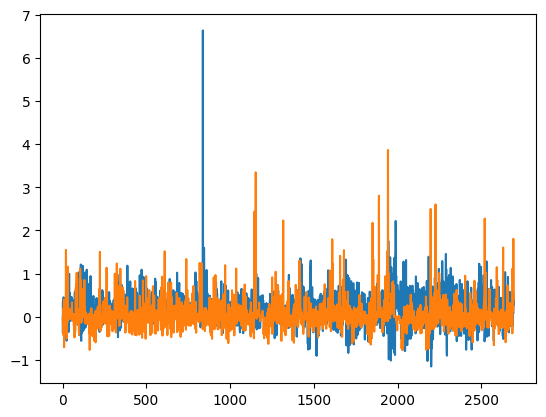

In [13]:
plt.plot(all_outputs)
plt.plot(all_truths)

In [14]:
# Fun Statistic Checker Code 

count_bound = 0
count_no_bound = 0

within_bounds_outputs = []
within_bounds_truths = []

max_truth, min_truth = np.max(all_truths), np.min(all_truths)
print(f"Max Truth Val: {max_truth}")
print(f"Min Truth Val: {min_truth}")

for idx, pred in enumerate(all_outputs):
    if pred >= -1 and pred <= 1 and all_truths[idx] >= -1 and all_truths[idx] <= 1:
        count_bound += 1
        within_bounds_outputs.append(all_outputs[idx])
        within_bounds_truths.append(all_truths[idx])
    else:
        count_no_bound+=1

print(f"Within Bound -1 to 1: {count_bound}")
print(f"Outside of -1 to 1: {count_no_bound}")

Max Truth Val: 3.8637616634368896
Min Truth Val: -0.7724792957305908
Within Bound -1 to 1: 2605
Outside of -1 to 1: 90


C:\Users\lordw\AppData\Local\Temp\ipykernel_36540\522657886.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


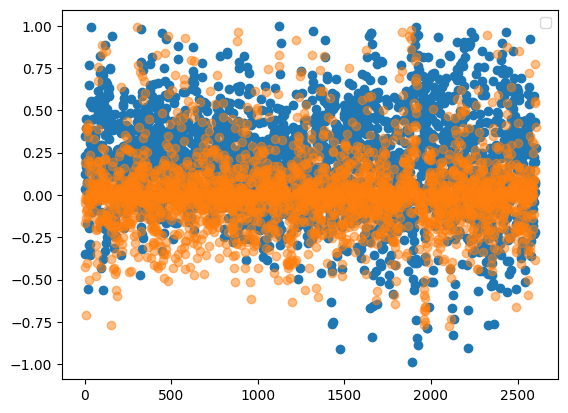

In [15]:
x = np.linspace(start=0, stop=len(within_bounds_outputs) - 1, num=len(within_bounds_outputs))

plt.scatter(x, within_bounds_outputs, alpha=1)
#plt.scatter(x, all_truths, alpha=0.05)
plt.scatter(x, within_bounds_truths, alpha=0.5)

plt.legend()

In [11]:
torch.save(model.state_dict(), "model_checkpoint.pth")
torch.save(model, "full_model.pth")